In [18]:
from ijcai2022nmmo import CompetitionConfig, scripted, TeamBasedEnv, Team
import nmmo
import numpy as np
import copy
import gym
import matplotlib.pyplot as plt
from gym import spaces 


class MyTrainEnv(gym.Env):
    def __init__(self,env_config:dict):
        self.config = CompetitionConfig()
        self.team_env = TeamBasedEnv(config)
        self.env_config = env_config
        #observation_space = [spaces.MultiDiscrete(2*np.ones((129,129),dtype=np.int32))]*8
        self.observation_space = spaces.Box(low=-np.infty,high=np.infty,shape=(129,129,80),dtype=np.float32)
        self.action_space = spaces.Box(low=-np.infty,high=np.infty,shape=(80,),dtype=np.float32)
        
    def reset(self):
        self.obs_by_team = self.team_env.reset()
        self.n_tick = 0 
        ##### establish the teams:
        self.teams = []
        self.teams += [MyAwesomeTeam("MyTeam",self.config)]
        team_config = self.env_config["teams"]
        for key, team_num in team_config.items():
            if team_num>0:
                designed_team = getattr(scripted,key)
                self.teams += [designed_team(key+f"-{i}",self.config) for i in range(team_num)] 
        ############################
        
        for team in self.teams:
            team.reset()
        
        # myteam population id = 0
        obs_to_myteam = obs_by_team[0]
        
        new_obs = self.teams[0].update_map(obs_to_myteam)
        return new_obs
        
    def step(self,action):
        actions = {}
        ####### convert the output of the policy into the true action
        new_my_action = sself.teams[0].act(action)
        
        
        actions[0]=new_my_actions
        ############
        
        ####### obtain the actions of other teams
        for team_index in range(1,16):
            other_actions = self.teams[team_index].act(self.obs_by_team[team_index])
            actions[team_index] = other_actions
        self.obs_by_team = self.team_env.step(actions)
        obs_to_myteam = self.obs_by_team[0]
        
        new_my_obs = self.teams[0].update_map(obs_to_myteam)
        
        self.n_tick += 1 
        ######## reward
        
        
        
        ######## done
        
        
        return new_my_obs,reward,done,info
        

In [45]:

########################
## Myteam
class MyAwesomeTeam(Team):
    def reset(self):
        # reset some states
        self.global_map = {}
        self.n_tick = 0 
        self.LOCAL_BIAS = 16
    
    def update_map(self,observations:dict[int,dict]):
        ############# terrian information
        agent_visible = np.zeros([129,129])
        agent_info = np.zeros([129,129,56])
        agents_dis = np.zeros([129,129])
        opponents=np.zeros([129,129,7])
        npcs=np.zeros([129,129,7])
        self.attack_objs = []
        for agent_index in range(8):
            attack_obj = []
            if observations.get(agent_index)!=None:
                obs_en = observations[agent_index]['Entity']['Continuous']
                team_id = int( obs_en[0][4] )
                agent_row_index = int( obs_en[0][5]- self.LOCAL_BIAS )
                agent_column_index = int( obs_en[0][6] - self.LOCAL_BIAS ) 
                opponents_loc = []
                npcs_loc = []

                for index in range(100):
                    info = int(obs_en[index][0])
                    if info==0:
                        break
                    entity_id = int(obs_en[index][1])
                    level = int( obs_en[index][3] )
                    pop = int( obs_en[index][4])
                    row_index = int( obs_en[index][5]- self.LOCAL_BIAS )
                    column_index = int( obs_en[index][6] - self.LOCAL_BIAS )
                    damage = int( obs_en[index][7] )
                    timealive = int( obs_en[index][8] )
                    food = int( obs_en[index][9] )
                    water = int( obs_en[index][10] )
                    health = int( obs_en[index][11] )
                    frozen = int( obs_en[index][12] )

                    if index==0:
                        # 表示是该team的agent
                        ######### 更新 agent_visible
                        agent_visible[int(max(row_index-7,0)):int(min(row_index+8,128)),
                                      int(max(column_index-7,0)):int(min(column_index+8,128))] = 1
                        ######### agent 更新 agent location
                        agent_info[row_index][column_index][agent_index*7+0]=1
                        ######### agent 更新 agent level
                        agent_info[row_index][column_index][agent_index*7+1]=level
                        ######### agent 更新 agent damage
                        agent_info[row_index][column_index][agent_index*7+2]=damage
                        ######### agent 更新 agent food
                        agent_info[row_index][column_index][agent_index*7+3]=food                            
                        ######### agent 更新 agent water
                        agent_info[row_index][column_index][agent_index*7+4]=water                                                                      
                        ######### agent 更新 agent health
                        agent_info[row_index][column_index][agent_index*7+5]=health
                        ######### agent 更新 agent frozen
                        agent_info[row_index][column_index][agent_index*7+6]=frozen
                        ######### agent 更新 timealive
                        self.n_tick = timealive
                        ######### agent 更新 agent dis
                        agents_dis[row_index][column_index]=1
                        #############################################################
                    else:
                        if pop>0 and pop!=team_id: # opponent
                            ######## opponent distribution
                            opponents[row_index][column_index][0]+=1
                            ######## level
                            opponents[row_index][column_index][1]+=level
                            ######## damage
                            opponents[row_index][column_index][2]+=damage
                            ######## food
                            opponents[row_index][column_index][3]+=food
                            ######## water
                            opponents[row_index][column_index][4]+=water                                
                             ######## health
                            opponents[row_index][column_index][5]+=health
                            ######## frozen
                            opponents[row_index][column_index][6]+=frozen

                            if [row_index,column_index] not in opponents_loc:
                                opponents_loc.append( [row_index,column_index] )
                            attack_obj.append([entity_id,
                                               abs(row_index-agent_row_index),
                                               abs(column_index-agent_column_index),
                                              level,
                                              damage,
                                              food,
                                              water,
                                              health,
                                              frozen])
                        elif pop<0: # npcs 
                            ######## npc distribution
                            npcs[row_index][column_index][0]+=1
                            ######## level
                            npcs[row_index][column_index][1]+=level
                            ######## damage
                            npcs[row_index][column_index][2]+=damage
                            ######## food
                            npcs[row_index][column_index][3]+=food
                            ######## water
                            npcs[row_index][column_index][4]+=water                                
                            ######## health
                            npcs[row_index][column_index][5]+=health
                            ######## frozen
                            npcs[row_index][column_index][6]+=frozen        

                            if [row_index,column_index] not in npcs_loc:
                                npcs_loc.append([row_index,column_index])
                                
                            attack_obj.append([entity_id,
                                               abs(row_index-agent_row_index),
                                               abs(column_index-agent_column_index),
                                              level,
                                              damage,
                                              food,
                                              water,
                                              health,
                                              frozen])
                for loc in opponents_loc:
                    for i in range(1,7):
                        opponents[loc[0]][loc[1]][i] = int( opponents[loc[0]][loc[1]][i]/opponents[loc[0]][loc[1]][0])
                for loc in npcs_loc:
                    for i in range(1,7):
                        npcs[loc[0]][loc[1]][i] = int(npcs[loc[0]][loc[1]][i]/npcs[loc[0]][loc[1]][0])
            self.attack_objs.append(np.array(attack_obj,dtype=np.float32))
        ##################### terrain update
        if self.global_map=={}: # first step
            terrain = np.zeros([129,129,8])  
            for agent_index in range(8):
                if observations.get(agent_index)!=None:
                    obs_til = observations[agent_index]['Tile']['Continuous']
                    for index in range(225):
                        til_type = int( obs_til[index][1] )
                        til_row = int( obs_til[index][2] -self.LOCAL_BIAS )
                        til_column = int( obs_til[index][3] -self.LOCAL_BIAS ) 
                        if til_row<0 or til_row > 128 or til_column<0 or til_column>128:
                            continue 

                        terrain[til_row][til_column][0]= 1
                        terrain[til_row][til_column][til_type]=1
        else:
            terrain = self.global_map['terrain']
            for i in range(129):
                for j in range(129):
                    if terrain[i][j][3]==1:
                        terrain[i][j][6]=1
                    if terrain[i][j][4]==1:
                        terrain[i][j][7]=1       
            for agent_index in range(8):     
                if observations.get(agent_index)!=None:
                    obs_til = observations[agent_index]['Tile']['Continuous']
                    for index in range(225):
                        til_type = int( obs_til[index][1] )
                        til_row = int( obs_til[index][2] -self.LOCAL_BIAS )
                        til_column = int( obs_til[index][3] -self.LOCAL_BIAS ) 
                        if til_row<0 or til_row > 128 or til_column<0 or til_column>128:
                            continue 

                        terrain[til_row][til_column][0]= 1
                        terrain[til_row][til_column][til_type]=1

                        if til_type==3 or til_type==4:
                            terrain[til_row][tile_column][6]=0
                            terrain[til_row][tile_column][6]=0
                                
        ######## concatenate                        
        self.global_map['terrain']=terrain
        self.global_map['oppos']=opponents
        self.global_map['npcs']=npcs
        agent_visible_expanded = np.expand_dims(agent_visible,axis=-1)
        agents_dis_expanded = np.expand_dims(agents_dis,axis=-1)
        myagents = np.concatenate( (agent_info,agent_visible_expanded,agents_dis_expanded),axis=-1 )
        self.global_map['agents']=myagents
        
        obs = np.concatenate( (myagents,opponents,npcs,terrain),axis=-1 )

        return obs
    
    def show_map(self,characters,attris,agent_index=0,terrain_option=False,ter_attris=[0,1,2,3,4,5,6,7]):
        """
        characters :  ["agents","oppos","npcs"]
        attris = [0,1,2,3,4,5,6]
        ter_attris = [0,1,2,3,4,5,6,7]
        
        """
        
        CHARAC = ['distribution','level','damage','food','water','health','is_frozen']
        AGENTS = ['visible','agents distribution']
        TERRAIN = ["exploration","water","grass","scrub(latest)","forest(latest)",
                   "stone","scrub(previous)","forest(previous)"]
        i = 0
        for character in characters:
            if character == "agents":
                for attri in attris:
                    plt.figure(i)
                    i+=1
                    ######## show agents 
                    plt.imshow(self.global_map[character][:,:,agent_index*8+attri],cmap=plt.cm.cool)
                    plt.colorbar()
                    plt.title(character+" "+CHARAC[attri])
                    plt.show()
                    
                plt.figure(i)
                i+=1
                plt.imshow(self.global_map[character][:,:,-2],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title(AGENTS[0])
                
                plt.figure(i)
                i+=1
                plt.imshow(self.global_map[character][:,:,-1],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title(AGENTS[1])                
            else:
                for attri in attris:
                    plt.figure(i)
                    i+=1
                    plt.imshow(self.global_map[character][:,:,agent_index*8+attri],cmap=plt.cm.cool)
                    plt.colorbar()
                    plt.title(character+" "+CHARAC[attri])
                    plt.show()    
        if terrain_option:
            terrains = self.global_map['terrain']
            for ter_attri in ter_attris:
                plt.figure(i)
                i+=1     
                
                plt.imshow(terrains[:,:,ter_attri],cmap=plt.cm.cool)
                plt.colorbar()
                plt.title("terrain "+TERRAIN[ter_attri])
                    
                    
    def act(self, observations: dict[int, dict]) -> dict[int, dict]:
        actions = {}
        for i, obs in observations.values():
            actions[i] = my_policy(obs)
        return actions
        


(129, 129, 80)


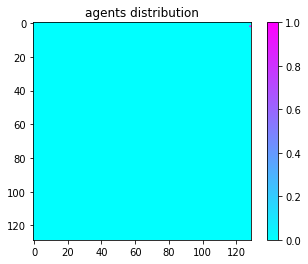

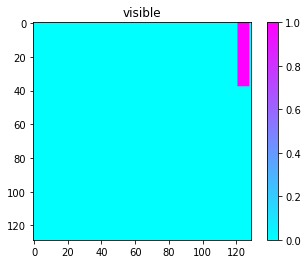

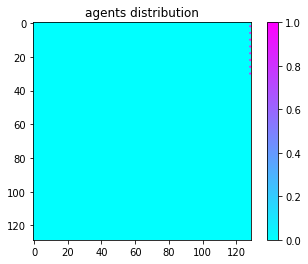

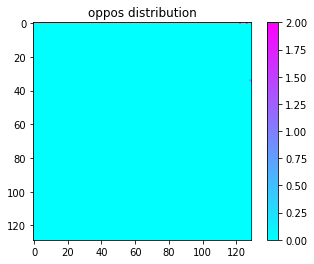

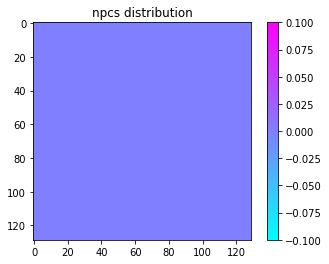

8


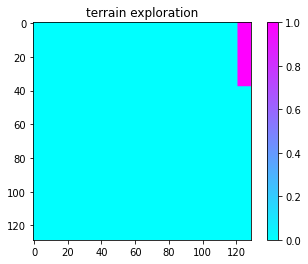

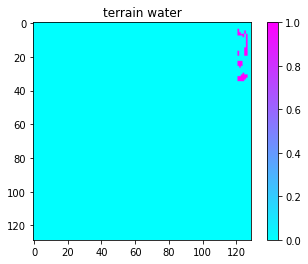

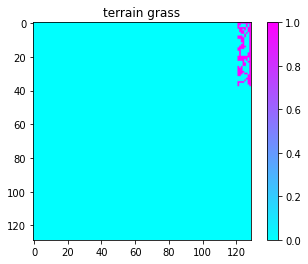

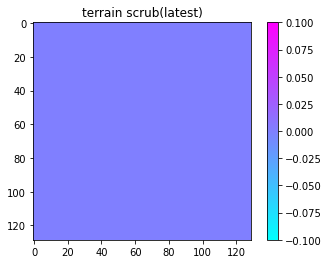

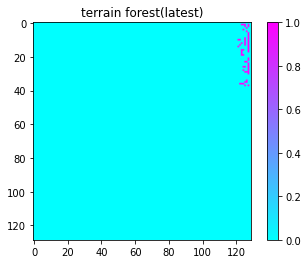

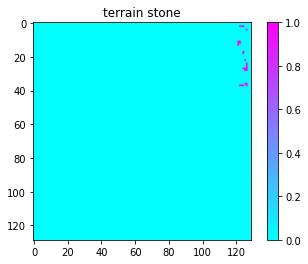

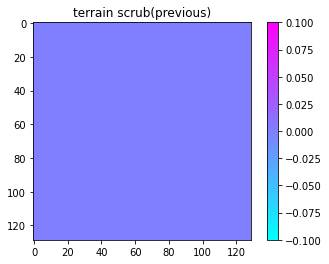

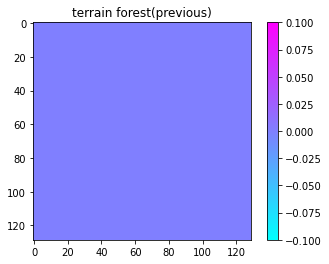

In [60]:
from ijcai2022nmmo import CompetitionConfig, scripted, TeamBasedEnv
import nmmo
import numpy as np
import matplotlib.pyplot as plt



Config = CompetitionConfig()
env = TeamBasedEnv(Config)
myteam = MyAwesomeTeam('myteam',Config)
myteam.reset()
obs = env.reset()
obs_team = obs[0]
new_obs = myteam.update_map(obs_team)
print(new_obs.shape)

myteam.show_map(["agents","oppos","npcs"],[0],agent_index=0,terrain_option=True,ter_attris=[0,1,2,3,4,5,6,7])

print( len(myteam.attack_objs) )  # attack_objs -> list[ np.ndarray(float32) ] 8个agent

In [58]:
import gym
from gym import spaces
import numpy as np

observe = [spaces.Box(low=-1.0,high=1.0,shape=(20,20),dtype=np.float32)]*3
print(tuple(observe))


(Box(-1.0, 1.0, (20, 20), float32), Box(-1.0, 1.0, (20, 20), float32), Box(-1.0, 1.0, (20, 20), float32))
